In [83]:
import time
from pathlib import Path
import json
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
import cv2

torch.set_printoptions(sci_mode=False, linewidth=200)

### Define directory with training files

In [ ]:
train_dir = Path('/home/mc/dev/dfdc_train/')

### Read metadata into a single dataframe

In [ ]:
metadata = list(train_dir.glob('*/*.json'))
dfs = []
for m in metadata:
    dfs.append(pd.read_json(m, orient='index').rename_axis('file').reset_index())
df = pd.concat(dfs, ignore_index=True)

### Add mp4 path to dataframe

In [ ]:
df['filepath'] = np.nan
df['filepath'] = df['filepath'].astype(object)
for i in range(len(df)):
    file = df.loc[i, 'file']
    mp4s = list(train_dir.glob(f'*/{file}'))
    if len(mp4s) > 0:
        df.at[i, 'filepath'] = mp4s[0].as_posix()

### For originals, add list of fakes to dataframe

In [ ]:
df['fakes'] = np.nan
df['fakes'] = df['fakes'].astype(object)
for i in range(len(df)):
    if df.loc[i, 'label'] == 'REAL':
        file = df.loc[i, 'file']
        fakes = df[df['original'] == file]['file'].to_list()
        df.at[i, 'fakes'] = fakes

### Save dataframe to pickle

In [ ]:
df.to_pickle('/home/mc/dev/deepfake-detection-challenge/notebooks/master_dataframe.pkl')

### Load dataframe from pickle

In [2]:
df = pd.read_pickle('/home/mc/dev/deepfake-detection-challenge/notebooks/master_dataframe.pkl')

### Get real videos and plot distribution of fakes per real video

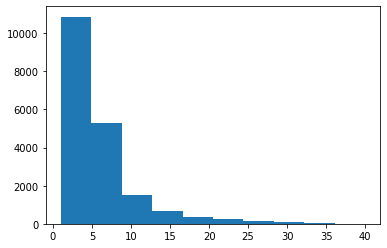

In [3]:
real_df = df[df['label'] == 'REAL'].reset_index()
num_fakes = []
for i in range(len(real_df)):
    num_fakes.append(len(real_df.loc[i, 'fakes']))
plt.hist(num_fakes);

### Function for converting mp4 files to numpy arrays

In [4]:
def mp4_to_npy(filepath):
    cap = cv2.VideoCapture(filepath)
    if not cap.isOpened(): 
        return np.array([])
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
        else: break
    return np.stack(frames)

### Find regions of frames where real videos differ from fake videos

In [ ]:
i = 0
j = 1

real_video_name = real_df.loc[i, 'file']
real_video_path = real_df.loc[i, 'filepath']
fake_video_name = real_df.loc[i, 'fakes'][j]
fake_video_path = df[df['file'] == fake_video_name]['filepath'].iloc[0]

print(real_video_name, real_video_path)
real_video = mp4_to_npy(real_video_path)
print(fake_video_name, fake_video_path)
fake_video = mp4_to_npy(fake_video_path)

In [ ]:
diff = fake_video.astype(float) - real_video.astype(float)
diff = np.absolute(diff).astype('uint8')
cutoff = 7 * np.ceil(np.mean(diff) + np.std(diff)).astype('uint8')
print(cutoff)

In [ ]:
def xywh_diff(img1, img2, cutoff):
    i1 = cv2.blur(img1, (11,11))
    i2 = cv2.blur(img2, (11,11))
    diff = i1.astype(np.float32) - i2.astype(np.float32)
    abs_diff = np.absolute(diff).astype('uint8')
    #cutoff = std_cutoff * np.ceil(np.mean(diff) + np.std(diff)).astype('uint8')
    x, y, _ = (diff > cutoff).nonzero()
    x1 = min(x)
    x2 = max(x)
    y1 = min(y)
    y2 = max(y)
    x = int((x1 + x2) / 2)
    y = int((y1 + y2) / 2)
    w = int(x2 - x1)
    h = int(y2 - y1)
    return x, y, w, h, img1[x1:x2, y1:y2], img2[x1:x2, y1:y2]

In [ ]:
img1 = real_video[0]
img2 = fake_video[0]
x, y, w, h, i1, i2 = xywh_diff(img1, img2, 30)
print(x,y,w,h)

In [ ]:
def video_diff_coords(video1, video2, cutoff):
    coords = []
    for i, j in zip(video1, video2):
        x, y, w, h, _, _ = xywh_diff(i, j, cutoff)
        coords.append(np.array([x, y, w, h]))
    return np.stack(coords)

In [ ]:
coords = video_diff_coords(real_video, fake_video, 20)

In [ ]:
width = max(coords[:, 2])
height = max(coords[:, 3])
print(width, height)

In [ ]:
x, y, w, h, i1, i2 = xywh_diff(real_video[0], fake_video[0], 10)
print(x, y, w, h)

In [ ]:
plt.imshow(i1)

In [ ]:
plt.imshow(i2)

In [ ]:
diff = np.absolute(i2.astype(float) - i1.astype(float)).astype('uint8')

In [ ]:
diff = np.absolute(real_video[0].astype(float) - fake_video[0].astype(float)).astype('uint8')

In [ ]:
plt.imshow(diff)

In [ ]:
plt.imshow(cv2.GaussianBlur(diff, (11,11), 1))

In [ ]:
np.max(cv2.GaussianBlur(diff, (11,11), 0))

In [ ]:
real_video[0].shape

In [ ]:
test_img = torch.Tensor(real_video[0].transpose(2, 0, 1).astype(np.float32)) / 255.0

### Face detection

In [ ]:
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
model.eval()

In [ ]:
with torch.no_grad(): pred = model([test_img])

In [ ]:
plt.imshow(test_img.permute(1, 2, 0));

In [ ]:
def plot_coords_on_img(img, coords):
    im = img.copy()
    for coord in coords:
        cv2.circle(im, tuple(coord), 10, (255, 0, 0), -1, 3)
    return im

def plot_box_on_img(img, coords):
    im = img.copy()
    cv2.rectangle(im, tuple(coords[:2]), tuple(coords[2:]), (255, 0, 0), 10)
    return im

In [ ]:
ann_img = test_img.permute(1, 2, 0).numpy()
coords = pred[0]['keypoints'][0].numpy().astype(int)[:, :2]
box = pred[0]['boxes'][0].numpy().astype(int)

In [ ]:
img = plot_coords_on_img(ann_img, coords)
img = plot_box_on_img(img, box)

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(img);

### Calculate face keypoints for real and fake videos

In [5]:
i = 0
j = 1

real_video_name = real_df.loc[i, 'file']
real_video_path = real_df.loc[i, 'filepath']
fake_video_name = real_df.loc[i, 'fakes'][j]
fake_video_path = df[df['file'] == fake_video_name]['filepath'].iloc[0]

print(real_video_name, real_video_path)
real_video = mp4_to_npy(real_video_path)
print(fake_video_name, fake_video_path)
fake_video = mp4_to_npy(fake_video_path)

acscknxbjl.mp4 /home/mc/dev/dfdc_train/dfdc_train_part_25/acscknxbjl.mp4
piaybeiamv.mp4 /home/mc/dev/dfdc_train/dfdc_train_part_25/piaybeiamv.mp4


In [6]:
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
model = model.cuda()
model.eval()
print('Model ready')

Model ready


In [81]:
def output_to_face_coords(pred):
    keypoints = pred['keypoints'][0][:5, :2].cpu().numpy() # nose, left_eye, right_eye, left_ear, right_ear
    scores = pred['keypoints_scores'][0][:5].cpu().numpy()
    scores = np.expand_dims(scores, 1)
    return np.hstack((keypoints, scores))

def video_to_face_coords(video):
    model_inp = torch.Tensor(video.transpose(0, 3, 1, 2).astype('float32') / 255.0)
    preds = []
    for i in model_inp:
        with torch.no_grad():
            pred = model([i.cuda()])
            preds.append(pred[0])
    preds = np.stack([output_to_face_coords(i) for i in preds])
    return preds

In [84]:
start = time.time()
pred = video_to_face_coords(real_video)
print(f'{time.time() - start:.2f}s')

19.57s


In [89]:
preds.shape

(300, 5, 3)